In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd
import itertools
import calendar

# ESIO Imports
import esio
import esiodata as ed

import dask
dask.set_options(get=dask.threaded.get)
# from dask.distributed import Client, progress
# client = Client(processes=12)

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.rcParams.update({'figure.max_open_warning': 0})

#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'metrics', 'extent')

In [2]:
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))

In [3]:
runType = 'forecast'
variables = ['sic']
cvar = variables[0]

In [4]:
# Define models to plot
# models_2_plot = list(E.model.keys())
# models_2_plot = [x for x in models_2_plot if x!='piomas'] # remove some models
models_2_plot = ['gfdlsipn',
 'yopp',
 'bom',
 'cma',
 'ecmwf',
 'hcmr',
 'isaccnr',
 'jma',
 'metreofr',
 'ukmo',
 'eccc',
 'kma',
 'ncep',
 'ukmetofficesipn',
 'ecmwfsipn',
 'usnavysipn',
 'usnavyncep']
#  'rasmesrl',
#  'noaasipn',
#  'noaasipn_ext']

## First, plot each model's (difference from obs, RMSE with initilization time, RMSE with forecast time, and Extent plots

gfdlsipn
yopp
bom
cma
ecmwf


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


hcmr
isaccnr
jma
metreofr
ukmo
eccc
kma
ncep
ukmetofficesipn
ecmwfsipn
usnavysipn
usnavyncep


<xarray.DataArray (model: 6, init: 365)>
array([[1.      , 0.964245, 0.938687, ...,      nan,      nan,      nan],
       [1.      , 0.94881 , 0.859625, ...,      nan,      nan,      nan],
       [1.      , 0.947008, 0.94174 , ..., 0.806223, 0.813064, 0.817606],
       [1.      , 0.986424, 0.979373, ..., 0.796553, 0.796317, 0.796833],
       [1.      , 0.730027, 0.665851, ...,      nan,      nan,      nan],
       [1.      , 0.737274, 0.220428, ...,      nan,      nan,      nan]])
Coordinates:
  * init           (init) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    approxdays     (model, init) timedelta64[ns] 0 days 3 days 6 days 9 days ...
  * model          (model) <U15 'ecmwf' 'metreofr' 'ukmo' 'ncep' ...
    fore_len_days  (model) int64 46 32 60 44 215 215

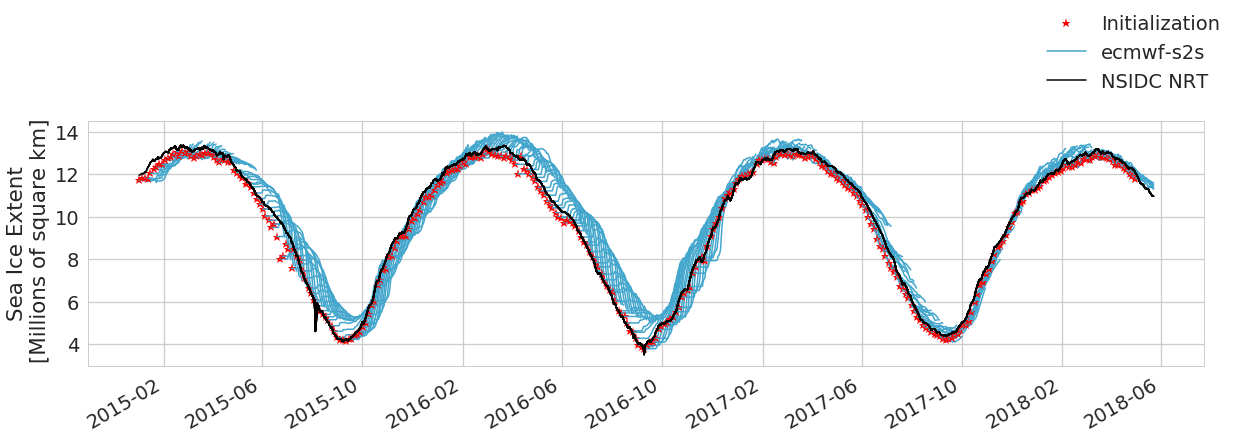

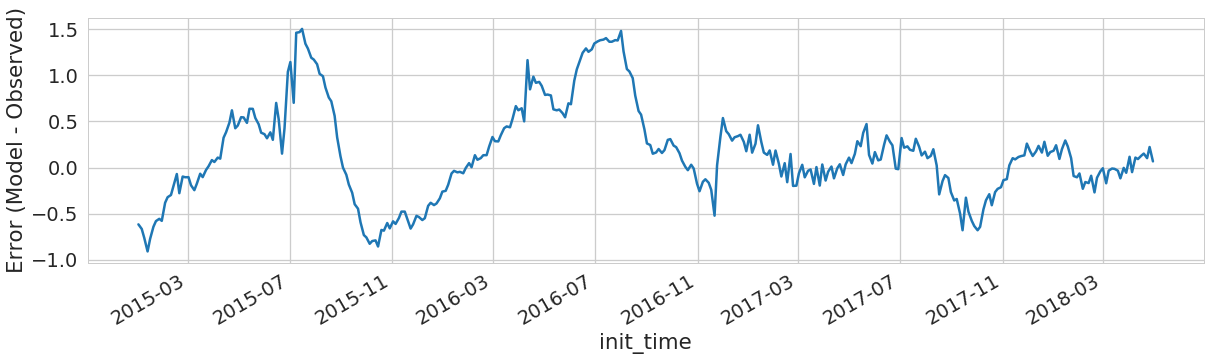

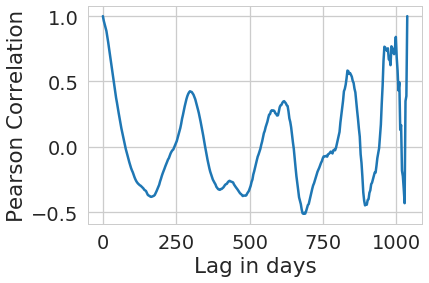

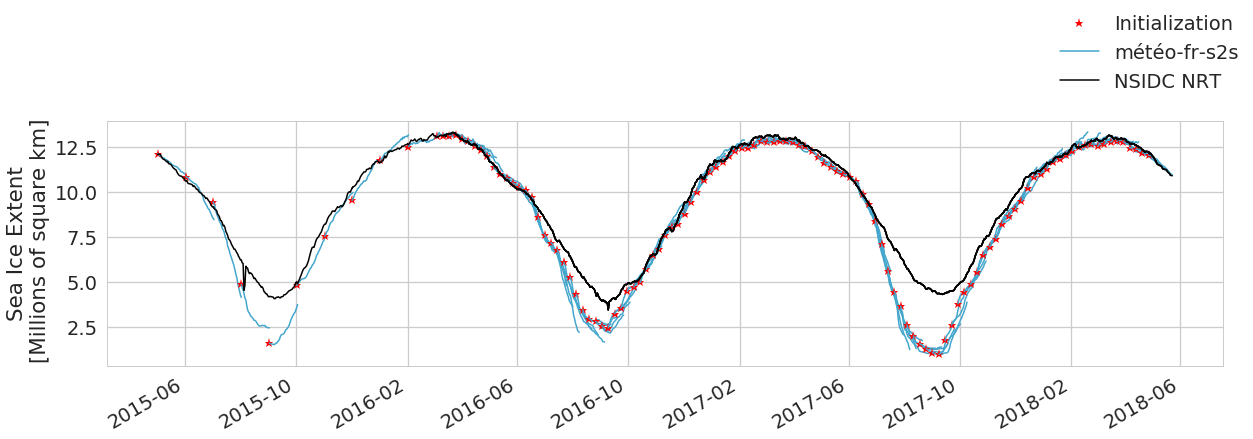

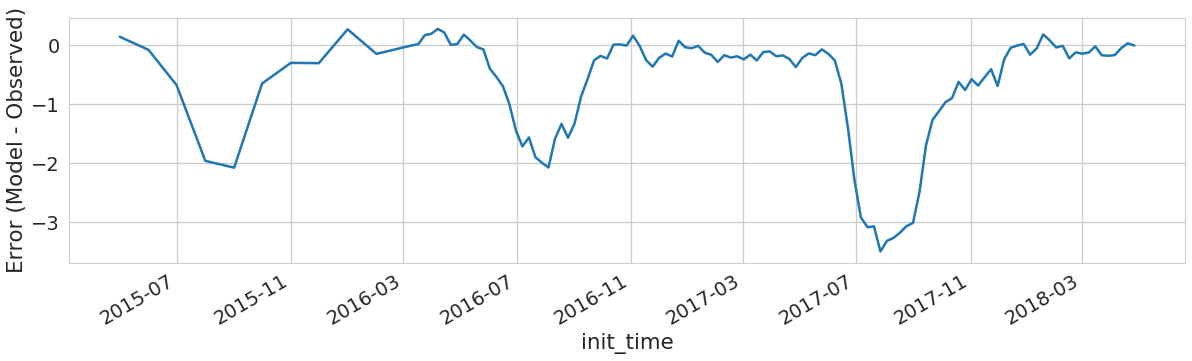

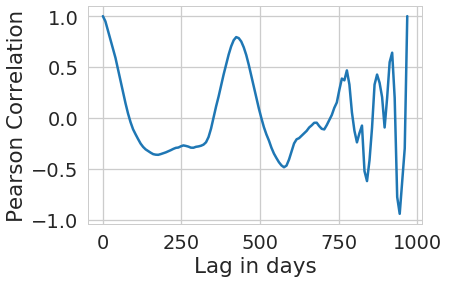

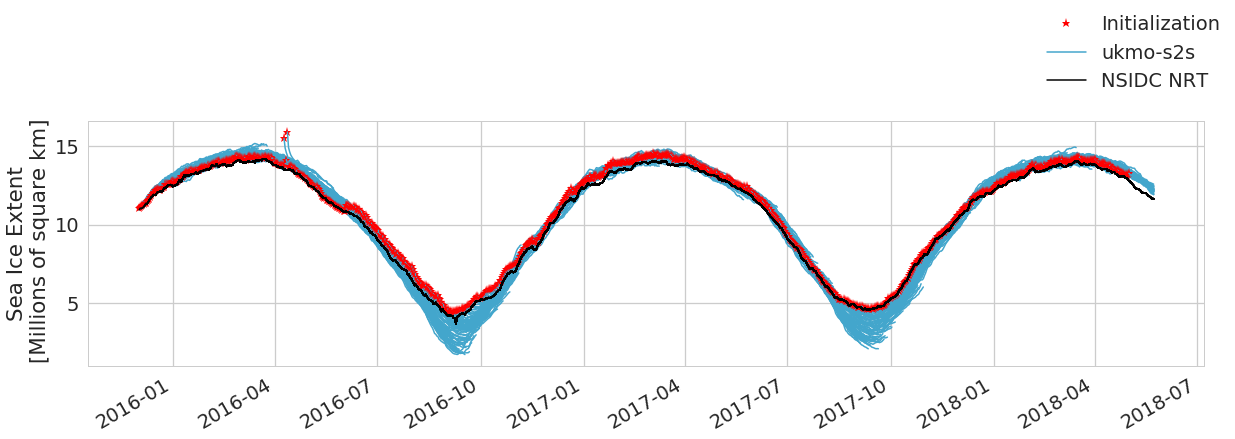

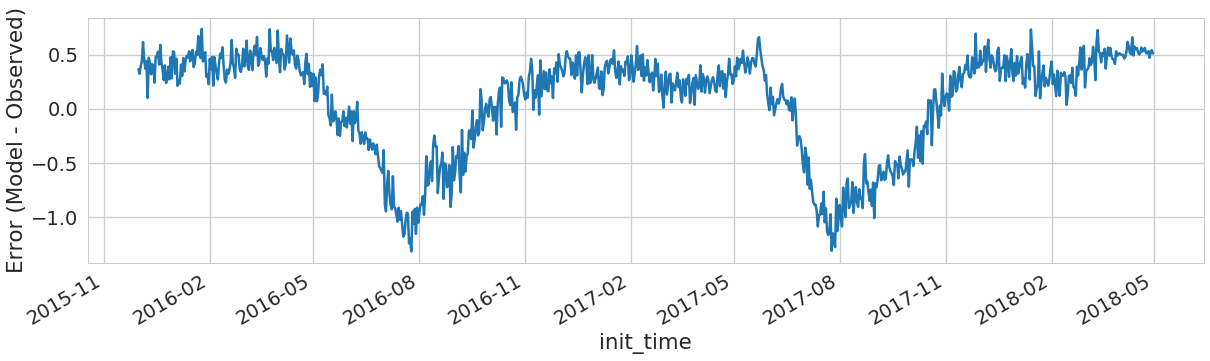

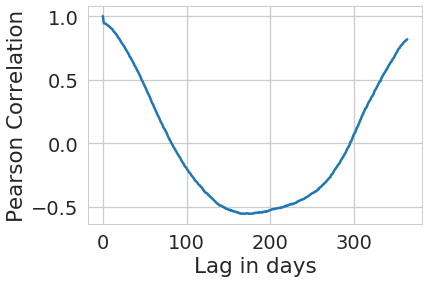

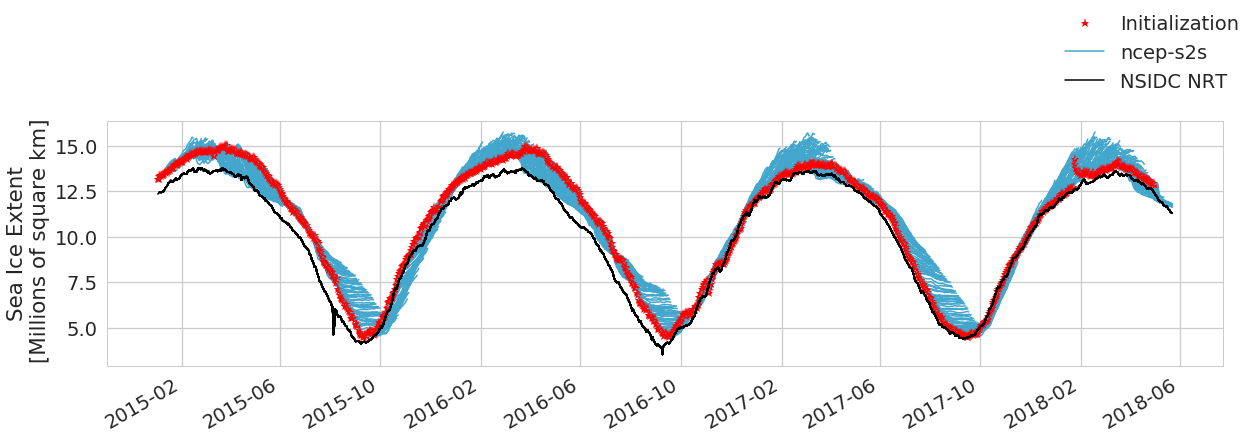

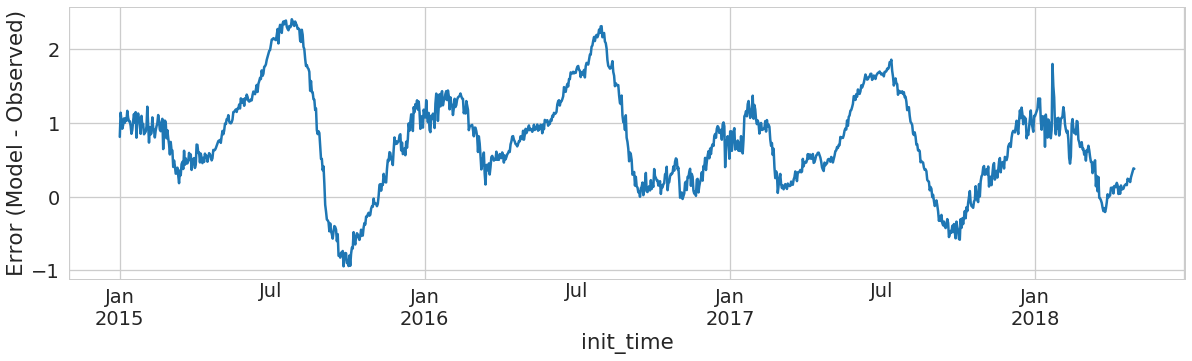

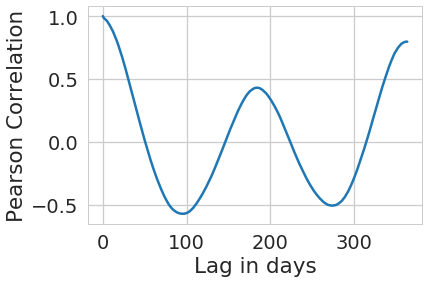

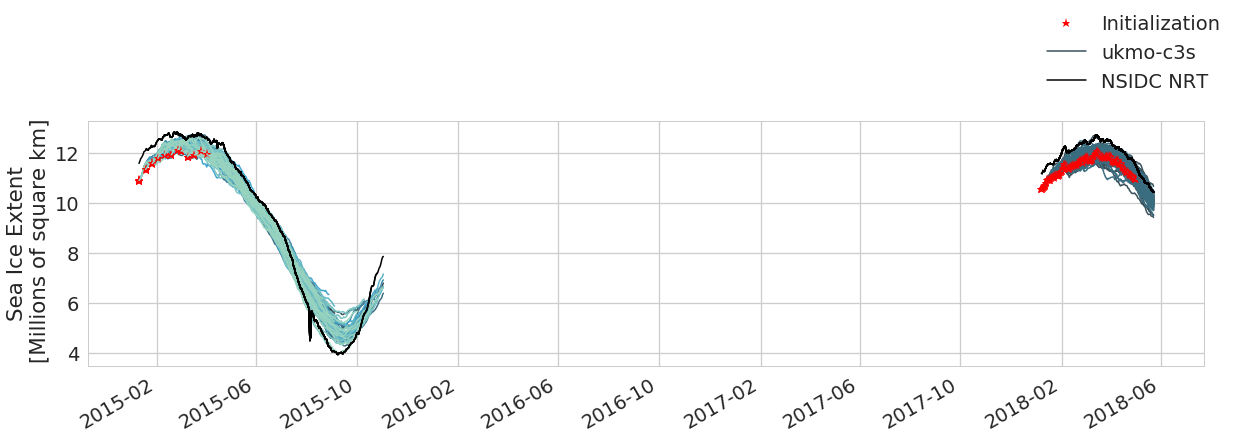

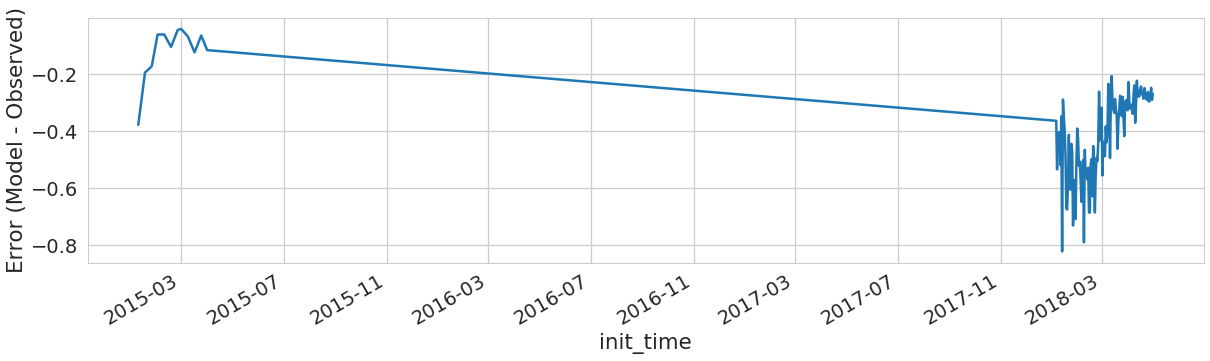

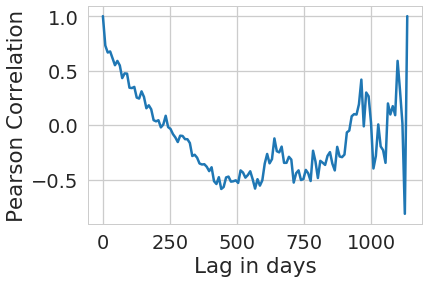

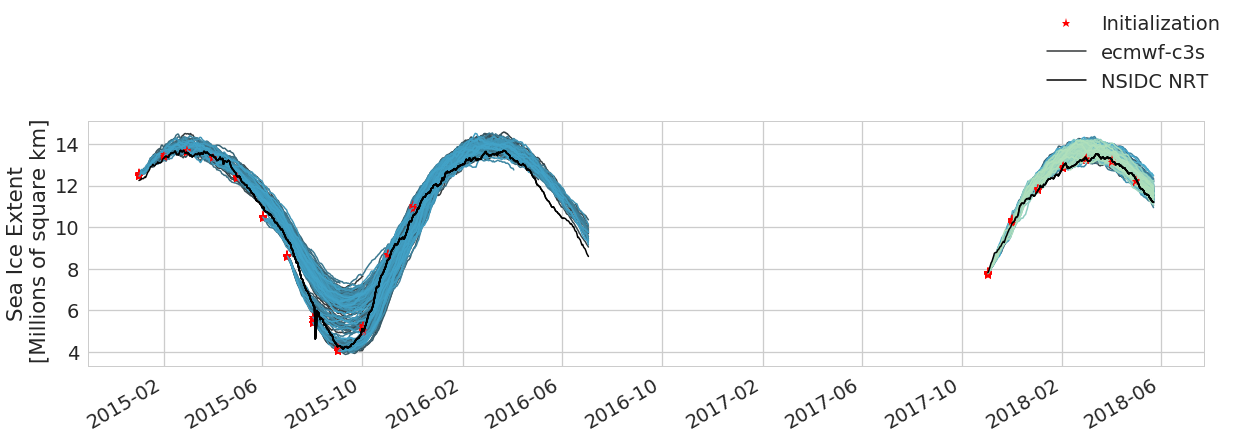

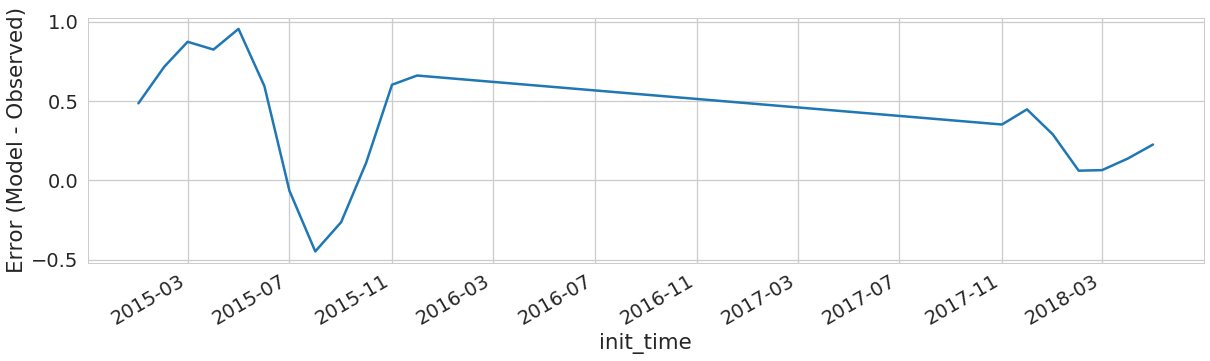

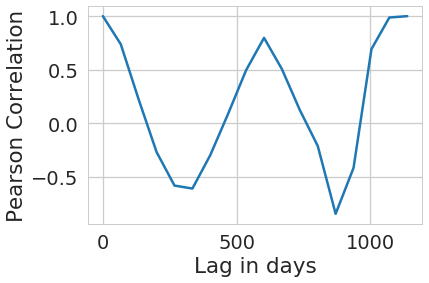

In [47]:
lag_l = []
for (i, c_model) in enumerate(models_2_plot):
    print(c_model)
    if not E.icePredicted[c_model]:
        continue
    
    c_fig_dir = os.path.join(fig_dir, c_model)
    if not os.path.exists(c_fig_dir):
        os.makedirs(c_fig_dir)
    
    # Load in data
    # Check file exists
    nc_file = os.path.join(data_dir, 'model', c_model , 'forecast', 'agg_nc', c_model+'_extent.nc')
    if os.path.isfile(nc_file):
        ds_mrg = xr.open_dataset(nc_file)
    else:
        print('No file found... skipping...')
        continue
        
    # Check that model record is atleast 2 years long
    len_days = (ds_mrg.init_time.values[-1] - ds_mrg.init_time.values[0]).astype('timedelta64[D]').astype('int')
    if len_days < 365*2: # two years
        continue

    # Plotting color maps
    cmap_diff = matplotlib.colors.ListedColormap(sns.diverging_palette(20,  220, n=21))
    # Calculate differences for each ensemble (0...N) from obseerved (-1)
    MOdiff = (ds_mrg[cvar].sel(ensemble=slice(0,ds_mrg.ensemble.size)) - ds_mrg[cvar].sel(ensemble=-1) )
    abs_max = np.max([MOdiff.min()*-1, MOdiff.max()])
    # Take average of ensemble and remove any times where we have no data in ensemble dim (missing obs)
    MOdiff_avg = MOdiff.mean(dim='ensemble')

    # Calc RMSE
    rmse_fore_time = np.sqrt( ( esio.nanSum(da=MOdiff_avg**2, dim='init_time')/MOdiff_avg.init_time.size) ).values
    rmse_init_time = np.sqrt( ( esio.nanSum(da=MOdiff_avg**2, dim='fore_time')/MOdiff_avg.fore_time.size) ).values
    
    # Plot pan-Arctic sea ice extent
    f = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(1, 1, 1) # Observations
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=slice(0,ds_mrg.ensemble.size)).sic, 
                         axin=ax1, labelin=E.model[c_model]['model_label'],
                         color='cycle_ensemble', marker=None)
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=-1).sic.expand_dims('ensemble'), 
                     axin=ax1, labelin='NSIDC NRT',
                     color='k', marker=None, init_dot=False)
#     ds_mrg.sel(ensemble=-1).sic.plot(label='NSIDC NRT', color='k')
    # ds_ext.Extent.plot(label='NSIDC V3', color='m')
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    plt.legend(loc='lower right',bbox_to_anchor=(1.03, 1.05))
    f.autofmt_xdate()
    plt.title('')
    
    # Calculate differences for each ensemble (0...N) from obseerved (-1)
    MOdiff = (ds_mrg[cvar].sel(ensemble=slice(0,ds_mrg.ensemble.size)) - ds_mrg[cvar].sel(ensemble=-1) )
    X = MOdiff.mean(dim='fore_time').mean(dim='ensemble').to_series()
    
    plt.figure(figsize=(20,5))
    X.plot()
    plt.gca().set_ylabel('Error (Model - Observed)')

    init_days = MOdiff.init_time.diff(dim='init_time').values.astype('timedelta64[D]')
    lagVal = np.arange(0,365)
    auto1 = [X.autocorr(lag=l) for l in lagVal]
    approxdays = lagVal*np.mean(init_days)
    
    c_da = xr.DataArray(auto1, dims=('init'), coords={'init':lagVal})
    c_da.coords['approxdays'] = xr.DataArray(approxdays, dims=('init'), coords={'init':lagVal})
    c_da.coords['model'] = c_model   
    c_da.coords['fore_len_days'] = MOdiff.fore_time.values[-1].astype('timedelta64[D]').astype('int') # Length of forecast in days
    lag_l.append(c_da)
    
    f = plt.figure()
    plt.plot(approxdays, auto1)
    plt.ylabel('Pearson Correlation')
    plt.xlabel('Lag in days')
# Concat
ds_lag = xr.concat(lag_l, dim='model')

Text(0.5,0,'Lag in days')

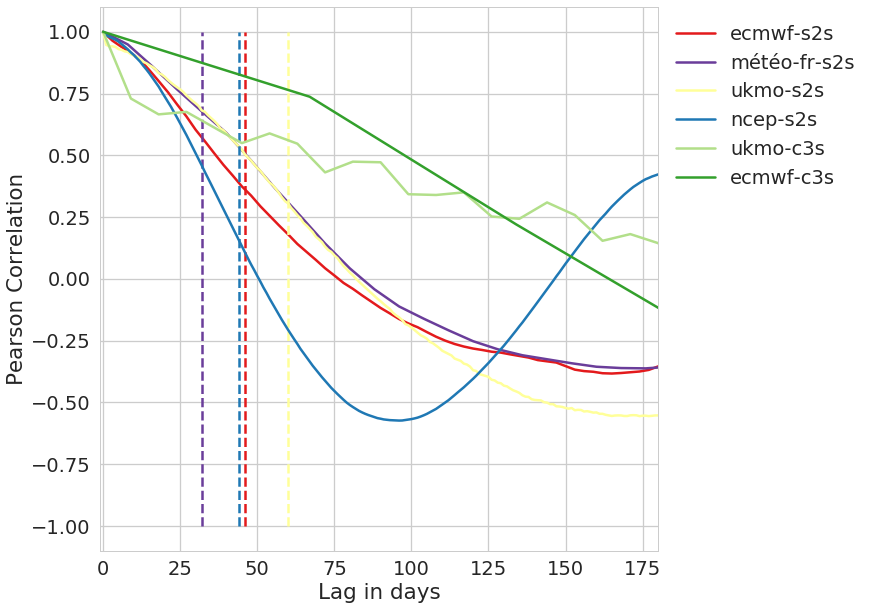

In [48]:
plt.figure(figsize=(10,10))
for cm in ds_lag.model:
    cds = ds_lag.sel(model=cm)
    cc = E.model_color[cm.item()]
    plt.plot(cds.approxdays.values.astype('timedelta64[D]'), cds.values, label=E.model[cm.item()]['model_label'], color=cc)
    plt.plot([cds.fore_len_days, cds.fore_len_days], [-1, 1], linestyle='--', color=cc)
plt.xlim([-1,30*6])
plt.legend(loc='upper left', bbox_to_anchor=[1,1])
plt.ylabel('Pearson Correlation')
plt.xlabel('Lag in days')
# Plot forecast length for aea

Text(0.5,0,'Lag in days')

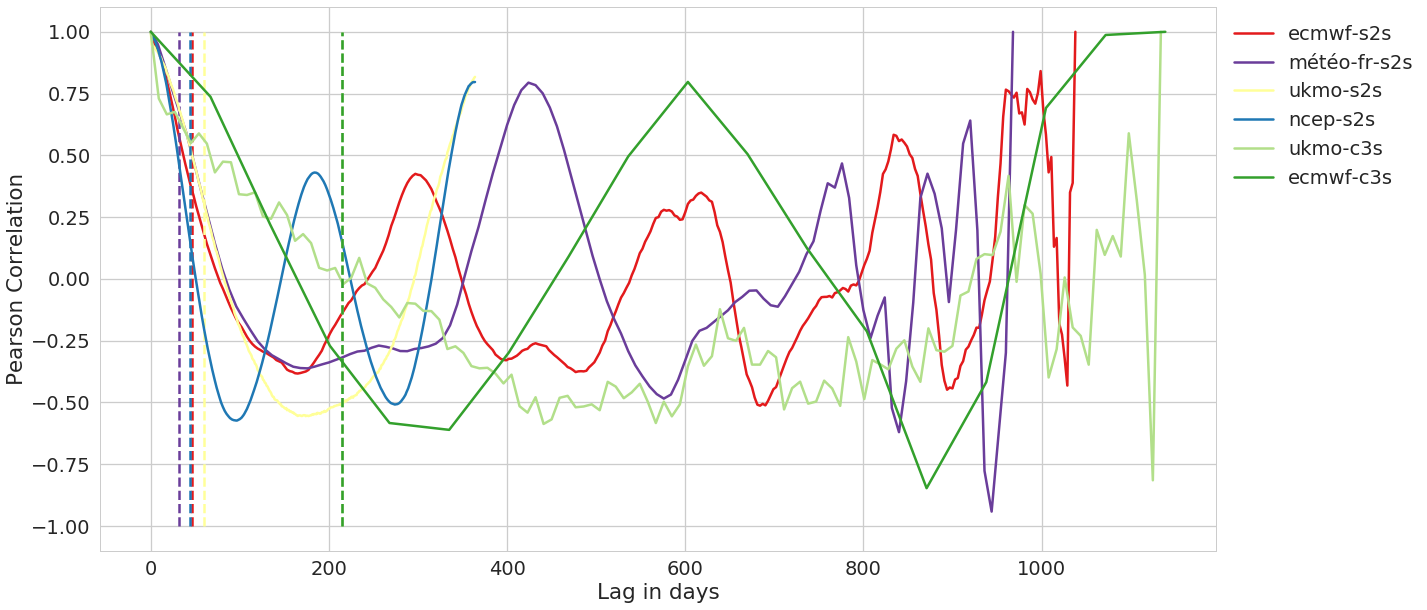

In [49]:
plt.figure(figsize=(20,10))
for cm in ds_lag.model:
    cds = ds_lag.sel(model=cm)
    cc = E.model_color[cm.item()]
    plt.plot(cds.approxdays.values.astype('timedelta64[D]'), cds.values, label=E.model[cm.item()]['model_label'], color=cc)
    plt.plot([cds.fore_len_days, cds.fore_len_days], [-1, 1], linestyle='--', color=cc)
# plt.xlim([-1,30*6])
plt.legend(loc='upper left', bbox_to_anchor=[1,1])
plt.ylabel('Pearson Correlation')
plt.xlabel('Lag in days')
# Plot forecast length for aea

In [40]:
ds_lag.fore_len_days

<xarray.DataArray 'fore_len_days' (model: 6)>
array([ 46,  32,  60,  44, 215, 215])
Coordinates:
  * model          (model) <U15 'ecmwf' 'metreofr' 'ukmo' 'ncep' ...
    fore_len_days  (model) int64 46 32 60 44 215 215

In [41]:
ds_lag

<xarray.DataArray (model: 6, init: 365)>
array([[1.      , 0.964245, 0.938687, ...,      nan,      nan,      nan],
       [1.      , 0.94881 , 0.859625, ...,      nan,      nan,      nan],
       [1.      , 0.947008, 0.94174 , ..., 0.806223, 0.813064, 0.817606],
       [1.      , 0.986424, 0.979373, ..., 0.796553, 0.796317, 0.796833],
       [1.      , 0.730027, 0.665851, ...,      nan,      nan,      nan],
       [1.      , 0.737274, 0.220428, ...,      nan,      nan,      nan]])
Coordinates:
  * init           (init) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    approxdays     (model, init) timedelta64[ns] 0 days 3 days 6 days 9 days ...
  * model          (model) <U15 'ecmwf' 'metreofr' 'ukmo' 'ncep' ...
    fore_len_days  (model) int64 46 32 60 44 215 215